# Predicting Movie Rental Durations
A DataCamp project in Python 

By Madison Martin

![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

# My Solution 

## Precleaning

In [26]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [27]:
# Load and view the data 
rental_df = pd.read_csv("rental_info.csv")
rental_df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [28]:
# Precleaning
# create rental_length_days column after changing to datetime 
rental_df["rental_length"] = pd.to_datetime(rental_df["return_date"]) - pd.to_datetime(rental_df["rental_date"])

rental_df["rental_length_days"] = rental_df["rental_length"].dt.days
# show the new column 
print(rental_df.head())

                 rental_date  ... rental_length_days
0  2005-05-25 02:54:33+00:00  ...                  3
1  2005-06-15 23:19:16+00:00  ...                  2
2  2005-07-10 04:27:45+00:00  ...                  7
3  2005-07-31 12:06:41+00:00  ...                  2
4  2005-08-19 12:30:04+00:00  ...                  4

[5 rows x 17 columns]


In [29]:
# create dummy variables from special_features 
# create one for deleted senes 
rental_df["deleted_scenes"] = np.where(rental_df["special_features"].str.contains("Deleted Scenes"), 1, 0)

#create one for BTS content 
rental_df["behind_the_scenes"] = np.where(rental_df["special_features"].str.contains("Behind the Scenes"), 1, 0)

The instructions ask to remove "columns that leak data about the target" before performing and evaluating any models. Since our target (dependent variable) is rental_length_days, we need to remove the original rental_date and return_date columns, as well as the columns we created - rental_length and rental_length_days. Additionally, since we used dummy coding for the special_features column, we need to remove it to avoid duplication of data within our models. 

In [30]:
# remove unneeded cols 
cols_to_drop = ["rental_date", "return_date", "rental_length", "rental_length_days", "special_features"]

# create feature and target sets 
X = rental_df.drop(cols_to_drop, axis=1)
y = rental_df["rental_length_days"]

## Identifying Best Models to Test

Before creating the actual models and evaluating them, we need to identify which models are appropriate for this business question. Since our target (dependent) variable of rental length days is quantitative, and we are working with data that has already been labeled with this target, we should utilize the supervised machine learning method of regression. 

Specifically, we will first perform standard **Multiple Linear Regression**. Then, we will perform regularized linear regression with a **Lasso model** so that we can perform feature selection. Finally, we will compare that to the performance of a **Random Forest Regressor model**, which also allows for hyperparameter tuning using **RandomizedSearchCV**.

In [31]:
# imports for mlr, lasso and OLS 
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [41]:
# basic multiple linear regression 
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

#evaluate performance 
y_pred = lin_reg.predict(X_test)
mse_linreg = mean_squared_error(y_test, y_pred)
print("Multiple Linear Regression MSE :", mse_linreg)

Multiple Linear Regression MSE : 2.9417238646975883


Off to a great start! The MSE of this multiple linear regression model is below 3, so we have already hit our target. However, let's keep trying our other propsective models to see if we can build one that is better performing. 

### Lasso Regularization and OLS Regression

In [32]:
# build and train lasso 
lasso = Lasso(alpha=0.3, random_state=9)
lasso.fit(X_train, y_train)

# perform feature selection using col coefficients > 0 
lasso_coef = lasso.coef_ 
X_lasso_train, X_lasso_test = X_train.iloc[:, lasso_coef > 0], X_test.iloc[:, lasso_coef > 0]

In [33]:
# Evaluate OLS model on chosen variables 
reg_ols = LinearRegression()
reg_ols = reg_ols.fit(X_lasso_train, y_train)
y_test_pred = reg_ols.predict(X_lasso_test)
mse_lasso = mean_squared_error(y_test, y_test_pred)
print("Lasso MSE :", mse_lasso)

Lasso MSE : 4.812297241276244


Oh no! Our Lasso regression did not yield a MSE less than 3, which is what the company asked for. We will carry on with building and evaluating the performance of a random forest model. 

### Random Forest Regressor and Randomized Search Tuning

In [34]:
# imports for random forest 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# create random forest model 
rand_for = RandomForestRegressor()

In [35]:
# create hyperparameter space 
param_dist = {'n_estimators': np.arange(1, 101, 1), 'max_depth': np.arange(1, 11, 1)} 

# use random search to find best hyperparameters
RCV = RandomizedSearchCV(rand_for, 
                        param_distributions=param_dist, 
                        cv=5, 
                        random_state=9)

# fit the model 
RCV.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])},
                   random_state=9)

In [36]:
# create a variable for best hyperparameters 
hyper_params = RCV.best_params_

# run random forest using best params 
rf = RandomForestRegressor(n_estimators=hyper_params["n_estimators"], 
                          max_depth=hyper_params["max_depth"], 
                          random_state=9)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [37]:
# Evaluate the random forest model 
mse_random_forest = mean_squared_error(y_test, rf_pred)
print("Random Forest MSE :", mse_random_forest)

Random Forest MSE : 2.225667528098759


Awesome! This is the best performing model on the company's selected metric (MSE), and is also below the threshold set of 3, so we will present this model as our final solution. 

In [48]:
# Solution
best_model = rf
best_mse = mse_random_forest

print("The best model is the Random Forest Regressor with a Mean Squared Error (MSE) of :", best_mse)

The best model is the Random Forest Regressor with a Mean Squared Error (MSE) of : 2.225667528098759


## Visualizing Performance of the Models 

In order to present my findings to the movie rental company, I will create this graphic to show that I created and tested three different models, and selected the one with with the best performance on their selected metric (MSE). Since MSE is difficult to interpret directly into real-world units, I would explain that the selected **Random Forest Model** has a MSE of around 2.2, so it has a RMSE of around 1.48, which means that on average, our model will be able to predict the customer's rental length accurately, give or take a day and a half. This should help immensely with their original business problem, which was increasing their efficiency in inventory planning!  

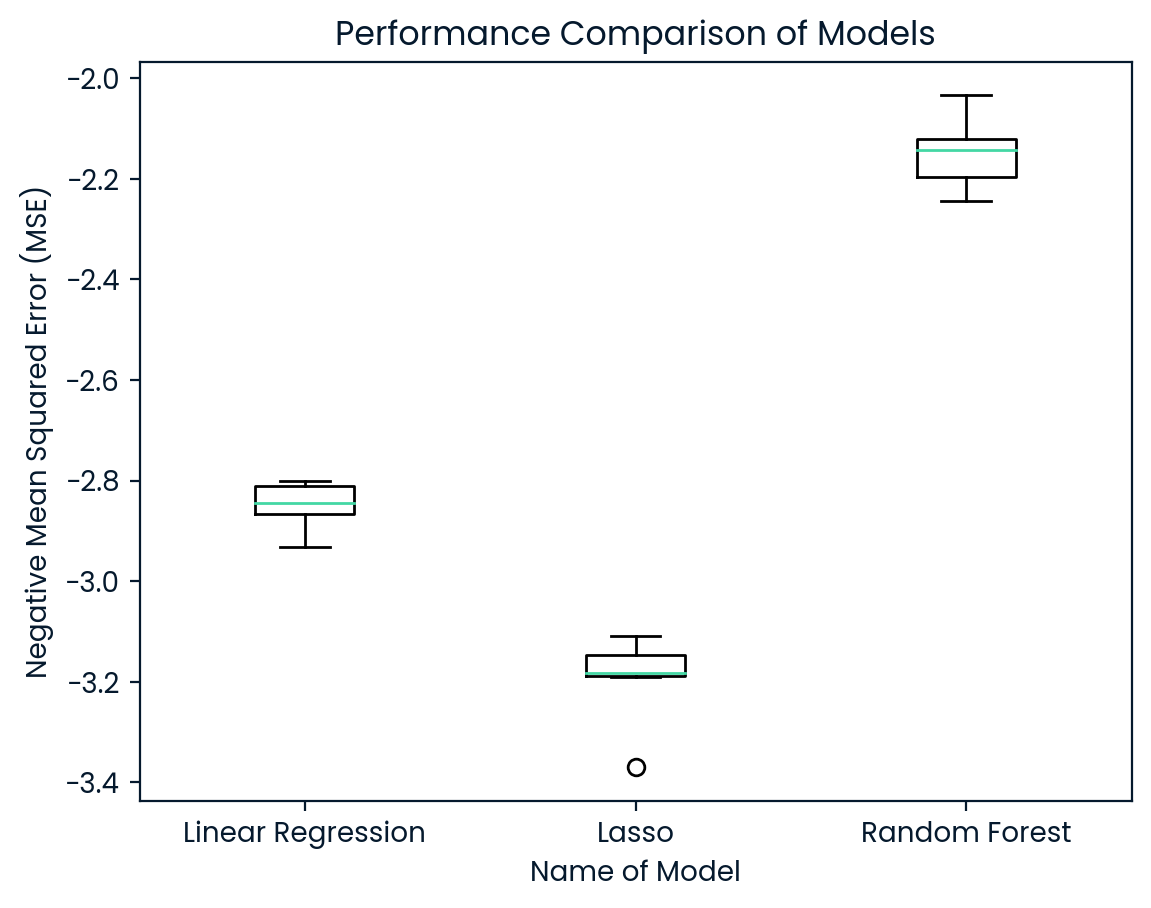

In [47]:
# import necessary packages 
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt

# create a loop to evaluate 3 models at once with cross validation
models = {"Linear Regression": LinearRegression(), "Lasso": lasso, "Random Forest": rf}
results = []

# Loop through the models' values
for model in models.values():
  kf = KFold(n_splits=6, random_state=9, shuffle=True)
  
  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring = "neg_mean_squared_error")
  
  # Append the results
  results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, labels=models.keys())
plt.title("Performance Comparison of Models")
plt.xlabel("Name of Model")
plt.ylabel("Negative Mean Squared Error (MSE)")
plt.show()